### New file

In [1]:
%matplotlib inline

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os

In [2]:
distros = ['mix', 'gau 1', 'gau 2', 'exp']
stepsizes = ['const', '2_div_sqrt_k', '0.002_div_sqrt_k']

tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]
N_g = 12 # N_generation
N_s = 10 # N_shuffle

N_q = len(tau_vals)

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))

In [3]:
main_fd = 'Experiment_results/'
fd_lst = ['Frugal_SGD', 'SGD']
for fd in fd_lst:
    if not os.path.exists(main_fd+fd):
        os.makedirs(main_fd+fd)
        
sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequence']        
for fd in sgd_lst:
    fd_name = main_fd+'SGD/'+fd
    if not os.path.exists(fd_name):
        os.makedirs(fd_name)

In [4]:
def get_settings(distro_lst, datasize_lst, stepsize_lst):
    len_lst = [len(distro_lst), len(datasize_lst), len(stepsize_lst)]
    if len_lst.count(1) != len(len_lst)-1: raise Exception("Setting inputs are wrong!")
    
    N_settings = max((len_lst))
    setting_lst = []
    for lst in [distro_lst, datasize_lst, stepsize_lst]:
        if len(lst)==1: 
            lst = lst*N_settings
        setting_lst.append(lst)
        
    changed_setting = None
    if len(distro_lst)>1:
        changed_setting = 'distro'
    elif len(datasize_lst)>1:
        changed_setting = 'data_size'
    elif len(stepsize_lst)>1:
        changed_setting = 'step_size'
    return np.asarray(setting_lst).T, changed_setting


In [5]:
def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau 1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau 2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [6]:
def get_dataset(distro, datasize, g_test=False):
    if g_test:
        dataset = np.zeros((N_g, datasize))
        for i in range(N_g):
            dataset[i] = get_one_dt(distro, datasize)
    else:
        dataset = get_one_dt(distro, datasize)
    return dataset

In [7]:
def get_q_true(distro, tau_lst):
    if tau_lst == tau_vals:
        if distro=='gau 1':
            return np.asarray([-21.06792817980280840537, 
                              -7.43920922874473411269,
                              2,
                              25.06792817980280840537,
                              43.87426173273513981594])
        elif distro=='gau 2':
            return np.asarray([-0.001281551565544600466965,
                              -5.244005127080407840383E-4,
                              0,
                              0.001281551565544600466965,
                              0.002326347874040841100886])
        elif distro=='mix':
            # sampled from 100000000 datapoints
            return np.asarray([-80.28496182,
                               -29.02324254,
                               -0.36011575,
                               36.69268923,
                               120.7676231])
        elif distro=='exp':
            return np.asarray([0.1053605156578263012275,
                              0.3566749439387323789126,
                              0.6931471805599453094172,
                              2.302585092994045684018,
                              4.605170185988091368036])*6.5 - 20
    raise Exception('tau_lst should be tau_vals')
    

In [8]:
def get_q_batch(dataset, tau_lst):
    if len(dataset.shape) != 1:
        raise Exception('Dataset for q_batch calculation of wrong shape: ' + str(dataset.shape))
        
    q_batch = np.zeros(len(tau_lst))
    for i, tau in enumerate(tau_lst):
        q_batch[i] = np.percentile(dataset, tau*100)
    return q_batch

In [9]:
def get_q_batches(dataset, tau_lst):
    # g_test = False
    if len(dataset.shape) == 1: 
        return get_q_batch(dataset, tau_lst)
    else:
        q_batches = np.zeros((dataset.shape[0], len(tau_lst)))
        for i in range(q_batches.shape[0]):
            q_batches[i] = get_q_batch(dataset[i], tau_lst)
    return q_batches

In [10]:
def set_stepsize(k, stepsize):
    if stepsize=='const':
        return 1
    elif stepsize=='2_div_sqrt_k':
        return 2/math.sqrt(k)
    elif stepsize=='0.002_div_sqrt_k':
        return 0.002/math.sqrt(k)
    raise Exception('stepsize parameter is wrong')

In [11]:
def get_procs(dataset, step_size, tau_lst):
    if len(dataset.shape)!= 1: 
        raise Exception('Dataset for get_procs() of wrong shape:' + str(dataset.shape)+ ', should be 1d array')
        
    procs = np.zeros((len(tau_lst), dataset.shape[0]))
    for idx, tau in enumerate(tau_lst):
        q = 0
        q_sgd_proc = procs[idx]
        # change stepsize
        if step_size != 'frugal':
            for k, x in enumerate(dataset):
#                 if idx==1: print (k, ':', q)
                alpha = set_stepsize(k+1, step_size)
                if x > q:
                    q = q + alpha*tau
                else:
                    q = q - alpha*(1-tau)
                q_sgd_proc[k] = q
        
        # frugal
        else:
            rdn_lst = np.random.uniform(0,1, dataset.shape[0])
            for k, x in enumerate(dataset):
                rdn = rdn_lst[k]
                if x > q and rdn > 1-tau:
                    q += 1
                elif x < q and rdn > tau:
                    q -= 1
                q_sgd_proc[k] = q
    return procs

In [12]:
# dataset = np.random.uniform(-100, 100, 1000)
# proc = get_procs(dataset, 'const', tau_vals)
# # print(proc[1])
# plt.plot(proc.T)

In [13]:
def get_res(procs):
    if len(procs.shape)!=2:raise Exception('Procs of wrong shape:' + str(procs.shape)+ ', should be 2d array')
    return procs[:, -1]

In [14]:
def get_q_ests(dataset, step_size, tau_lst):

    if len(dataset.shape)>2:
        raise Exception('Dataset for q_est calculation of wrong shape:' + str(dataset.shape)+ ', should be 1d or 2d array')
    if len(dataset.shape)==1:
        procs = get_procs(dataset, step_size, tau_lst)
        res = get_res(procs)
    else:
        res = np.zeros((dataset.shape[0], len(tau_lst)))
        procs = np.zeros((dataset.shape[0], len(tau_lst), dataset.shape[1]))
        for idx, dt in enumerate(dataset):
            procs[idx] = get_procs(dt, step_size, tau_lst)
            res[idx] = get_res(procs[idx])
    return res, procs

In [15]:
# dataset = get_dataset('gau 1', 1000, g_test=True) * 50 - 200
# print(dataset.shape)

# # proc1 = get_procs(dataset, 'const', tau_vals)
# ## res1 = get_res(proc1)
# # proc2 = get_procs(dataset, 'frugal', tau_vals)
# # plt.plot(proc1.T)ad
# # plt.plot(proc2.T)
# # plt.show()


# res, proc = get_q_ests(dataset, 'const', tau_vals)
# print(res)
# print(proc)

In [16]:
def get_normalized_e(true, batches, est):
    upper = est - batches
    bottom = true - batches
    return (upper/bottom)

### Plots

In [17]:
def naming(distro, datasize, stepsize, tau_list, g_test, s_test):
    return [1, 2, 3]
#     return 3 differnt names?

In [18]:
dataset = get_dataset('mix', 1000, True)
q_batches = get_q_batches(dataset, tau_vals)
q_true = get_q_true('mix', tau_vals)
sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_vals)
E = get_normalized_e(q_true, q_batches, sgd_res)

print (E[3])

[-0.11218545 -5.0029626  45.81465784  0.0585677  11.0579765 ]


In [19]:
def plot_one_proc(tau_lst, q_proc, ax, label_on):
    for idx, q in enumerate(q_proc):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+'-quantile' if label_on else ''
        ax.plot(q, color=colorVal, label=lb)  

# fig, ax = plt.subplots(1,1)
# plot_one_proc(tau_vals, sgd_proc, ax, True)

In [41]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
#     import matplotlib.colors as mc
    import colorsys
    try:
        c = colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def plot_procs_error_bar(ax, tau_lst, q_true, q_procs, Frugal):
    N_dim = len(q_procs.shape)

    if q_true is not None:
        if len(q_true.shape)==2: q_true = q_true.mean(axis=0)
        for idx, q in enumerate(q_true):
            colorVal = scalarMap.to_rgba(tau_lst[idx])                
            ax.axhline(q, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
    if N_dim == 2:
        plot_one_proc(tau_lst, q_procs, ax, True)
            
    elif N_dim == 3: 
        proc_mean = np.mean(q_procs, 0)
        proc_max = np.max(q_procs, 0) - proc_mean
        proc_min = proc_mean - np.min(q_procs, 0) 
        
        for i in range(len(tau_lst)):
            
            err = np.vstack((proc_max[i], proc_min[i]))
            colorVal = scalarMap.to_rgba(tau_lst[i])
            ax.errorbar(np.arange(proc_mean.shape[-1]),
                        proc_mean[i], 
                        yerr=err, ecolor = lighten_color(colorVal, 0.4),
                        color=colorVal, 
                        label = str(tau_lst[i])+'-q'+(' Frugal' if Frugal else ' SGD'))

    ax.set_xlabel('Number of Samples')

    

def plot_procs(ax_name, tau_lst, q_true, q_procs, q_compare=None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    

    plot_procs_error_bar(ax, tau_lst, q_true, q_procs, (q_compare is not None))
    
    if q_compare is not None:
        for idx, proc in enumerate(q_compare):
            colorVal = scalarMap.to_rgba(tau_lst[idx])
            ax.plot(proc, color = lighten_color(colorVal, 1.6),
                   label = str(tau_lst[idx])+'-q SGD')
    
    lgd = ax.legend(loc='right', bbox_to_anchor=(0.65, -0.25),
    frameon=False, ncol=(3 if ((q_true is not None) and (q_compare is not None)) else 2))
    ax.set_title(ax_name)
    ax.set_ylabel('Quantile Value')

    return fig, lgd


_, compare_proc = get_q_ests(dataset, '2_div_sqrt_k', tau_vals)

# plot_procs('ax_name', tau_vals, q_batches, sgd_proc)

In [35]:
def plt_stripe(tau_lst, ax, q_lst, pattern, name, hist_on):
#     hist_on = (len(q_lst.shape) > 2)
    q_lst = q_lst.T
    for idx, q in enumerate(q_lst):
        colorVal = scalarMap.to_rgba(tau_lst[idx])
        lb = str(+tau_lst[idx])+name
        if not hist_on:
            line = ax.plot([q,q], [0,1], pattern, color=colorVal)
            line[0].set_label(lb)
        else:
            bins = 10
            line = ax.hist(q.reshape(-1), bins, color=colorVal, label=lb)

def plot_spectrum_stripes(ax_name, q_lst, q_batches, q_sgd_res):
    c_Norm = colors.Normalize(vmin=0, vmax=1)
#     scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('cool'))
    styles = ['-', '--']
    names = ['-q batch', '-q sgd   ']
    
    fig = plt.figure(figsize=(16,4))
    ax_batch = fig.add_subplot(211)
    ax_sgd = fig.add_subplot(212, sharex = ax_batch)
    
    
    plt_stripe(q_lst, ax_batch, q_batches, styles[0], names[0], False)
    plt_stripe(q_lst, ax_sgd, q_sgd_res, styles[1], names[1], False)

    #set 
    ax_batch.set_xlabel('batch value')
    ax_batch.xaxis.set_label_coords(0.04, 0.98)
    ax_batch.set_yticks([])
    ax_batch.set_title(ax_name)

    plt.locator_params(axis='x', nbins=10)

    ax_sgd.set_xlabel('sgd value')
    ax_sgd.xaxis.set_label_coords(0.035, 0.98)
    ax_sgd.set_yticks([])

    # set position of legend
    ax_batch.legend(loc='lower center', bbox_to_anchor=(0.5, -1.8),
            frameon=False, ncol=len(q_lst))
    lgd = ax_sgd.legend(loc='lower center', bbox_to_anchor=(0.5, -0.8),
        frameon=False, ncol=len(q_lst))
        
    return fig, lgd       

# plot_spectrum_stripes('ax name', tau_vals, q_batches, sgd_res)

In [36]:
from matplotlib.ticker import PercentFormatter

def plot_E_res(ax_name, tau_lst, e):
    e = e.T
    if len(e.shape)>2: raise Exception('E shape is too high!')
    fig, axes = plt.subplots(nrows=len(tau_lst), sharex=True)
    fig.set_size_inches(14, 8)
    for i, ax in enumerate(axes):
        if i==0: ax.set_title(ax_name)
        if i==len(tau_lst)-1: ax.set_title('Error value', y=-0.5)
        colorVal = scalarMap.to_rgba(tau_lst[i])
        ax.hist(e[i], weights=np.ones(len(e[i]))/len(e[i]), bins=10, color=colorVal)
        ax.plot([e[i].mean(), e[i].mean()], [0,1], color='black')
        ax.set_xlabel((str(tau_lst[i])+'-quantile'))
        ax.xaxis.set_label_coords(0.95, 0.97)
        ax.yaxis.set_major_formatter(PercentFormatter(1))
#         ax.plot([e[i].mean(), e[i].mean()], [0,1], color='black')
    fig.suptitle('Histogram for Error Values', y = 0.94)
    return fig
# plot_E_res('axname', tau_vals, E)

In [37]:
def plot_charts(folder_name, plot_name, tau_lst, q_batches, sgd_res, sgd_proc, q_true, e):
    
#     print ("compare results with stripe plots")
    category, setting = plot_name[0], plot_name[1]
    ax_name = 'Tested on '+category+': '+str(setting)
    file_name = folder_name+str(setting)
    
    
    fig_res, lgd_res = plot_spectrum_stripes(ax_name, tau_lst, q_batches, sgd_res)
    title = fig_res.suptitle('Batch vs SGD quantile results')
    plt.savefig(file_name+"_res.png", bbox_extra_artists=[lgd_res, fig_res], bbox_inches='tight')
    

    fig_proc, lgd_proc = plot_procs(ax_name, tau_lst, q_true, sgd_proc)
    fig_proc.suptitle('SGD Quantile Estimation Processes')
    plt.savefig(file_name+"_proc.png", bbox_extra_artists=[lgd_proc, fig_proc], bbox_inches='tight')

    
#     print ("compare E results")
#     e = compute_E_res(q_lst, q_batches, q_sgd_res)
    fig_err = plot_E_res(ax_name, tau_lst, e)
    plt.savefig(file_name+"_err.png")
    
    return 4

In [38]:
# plot_charts('', ('mix', 1000), tau_vals, q_batches, sgd_res, sgd_proc, q_batches, )

### Main functions 

In [39]:
def get_plot_name(changed_setting, distro, datasize, stepsize, s_test):
    print(changed_setting)
    if s_test:
        return ('Shuffle', True)
    elif changed_setting=='distro':
        return ('Distribution', distro)
    elif changed_setting=='data_size':
        return ('Data size', datasize)
    elif changed_setting=='step_size':
        return ('Step size', stepsize)
    else: raise Exception ('Cannot get plot name')

In [26]:
def quantile_sgd_compare(folder_name, distro_lst, datasize_lst, stepsize_lst, 
                         g_test=False, s_test=False, tau_lst=tau_vals, 
                        ):
    
    if g_test and s_test: raise Exception("g_test and s_test can't both be true")
    
    # generate different settings
    setting_lst, changed_setting = get_settings(distro_lst, datasize_lst, stepsize_lst,)
    print (setting_lst)
    # if only stepsize changes, generate dataset and q_batches
    dataset, q_batches = 0, 0
    if changed_setting=='step_size':
        dataset = get_dataset(distro_lst[0], datasize_lst[0], g_test)
        q_batches = get_q_batches(dataset, tau_lst)
        
    # for each setting = [distro, datasize, stepsize]
    for idx, setting in enumerate(setting_lst):
        # generate all the data
        distro, datasize, stepsize = setting[0], int(setting[1]), setting[2]
        q_true = get_q_true(distro, tau_lst)
        if changed_setting != 'step_size':
            dataset = get_dataset(distro, datasize, g_test)
            q_batches = get_q_batches(dataset, tau_lst)
        if s_test:
            shuffled_dt = np.zeros((N_s, datasize))
            for i in range(N_s):
                np.random.shuffle(dataset)
                shuffled_dt[i] = dataset
            dataset = shuffled_dt
        q_est_res, q_est_proc = get_q_ests(dataset, stepsize, tau_lst)
        E = get_normalized_e(q_true, q_batches, q_est_res)
#         print(E)
        
#         # generate charts and tables?
        plot_name = get_plot_name(changed_setting, distro, datasize, stepsize, s_test)
        plot_charts(folder_name, plot_name, tau_lst, q_batches, q_est_res, q_est_proc, q_true, E)

distro
[['mix' '1000' 'const']
 ['gau 1' '1000' 'const']
 ['gau 2' '1000' 'const']
 ['exp' '1000' 'const']]
distro
distro
distro
distro
data_size
[['gau 1' '100' 'const']
 ['gau 1' '1000' 'const']
 ['gau 1' '100000' 'const']]
data_size
data_size
data_size


/Users/sue/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


step_size
[['gau 1' '1000' 'const']
 ['gau 1' '1000' '2_div_sqrt_k']
 ['gau 1' '1000' '0.002_div_sqrt_k']]
step_size
step_size
step_size
data_sequence
[['gau 1' '1000' 'const']
 ['gau 1' '1000' 'const']]
distro
distro


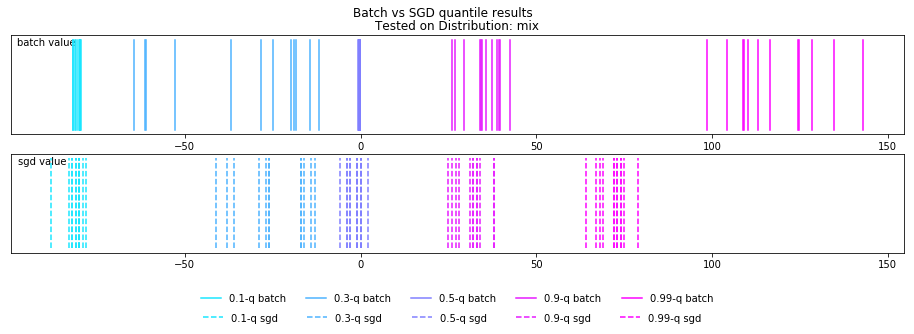

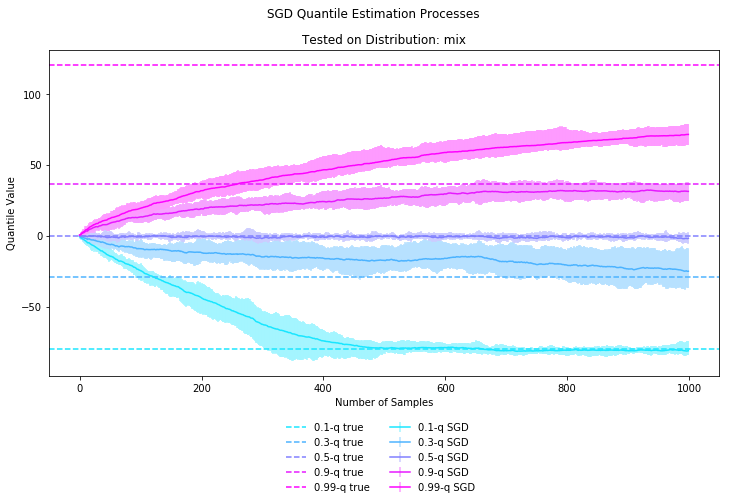

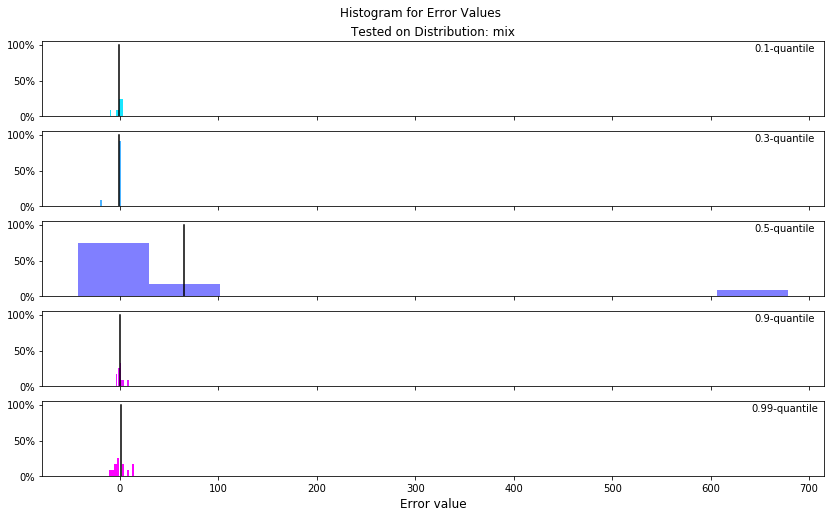

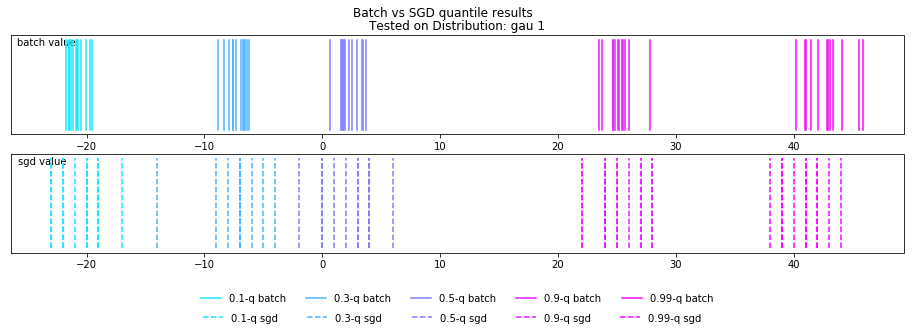

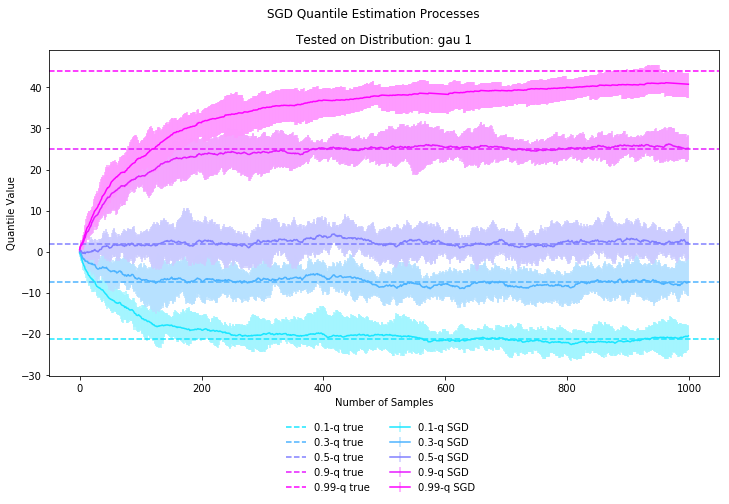

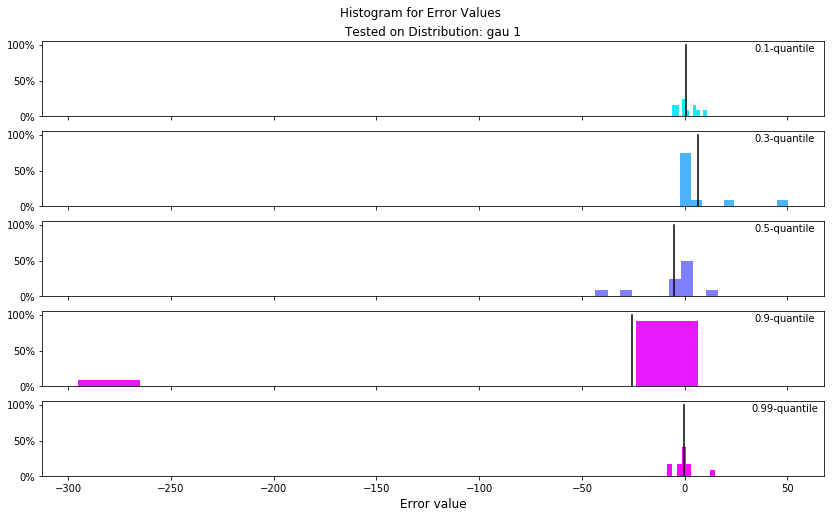

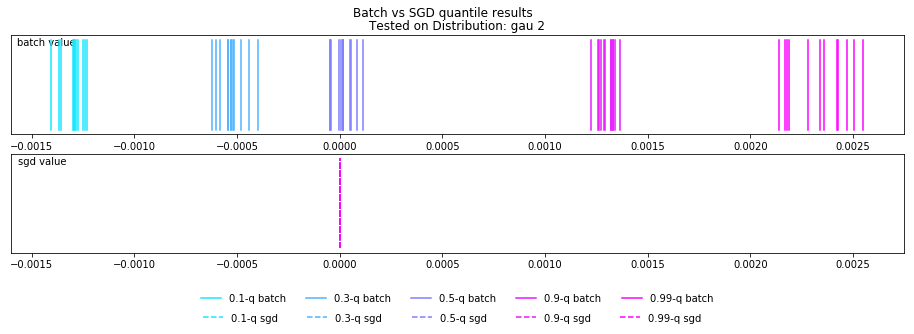

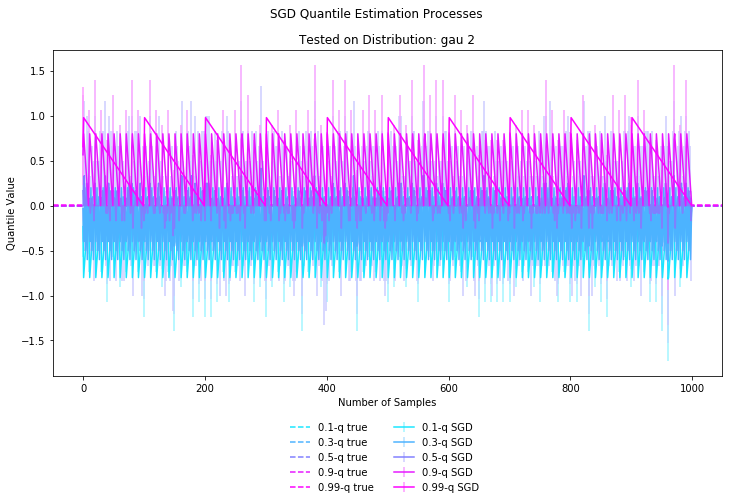

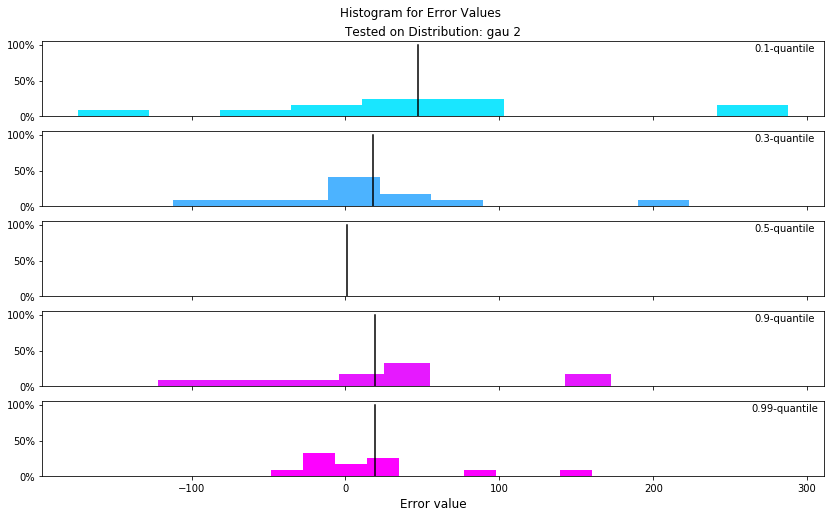

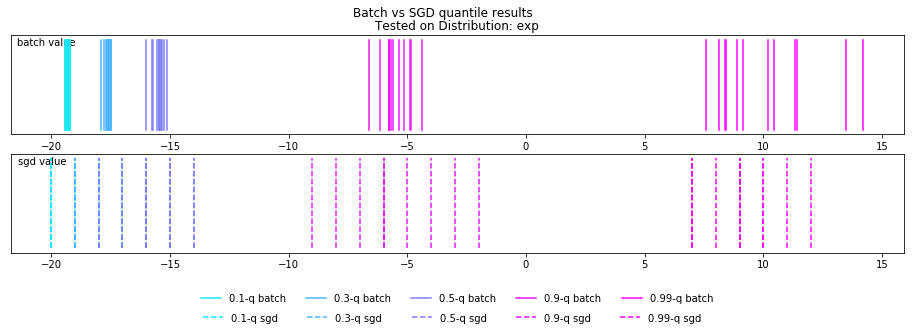

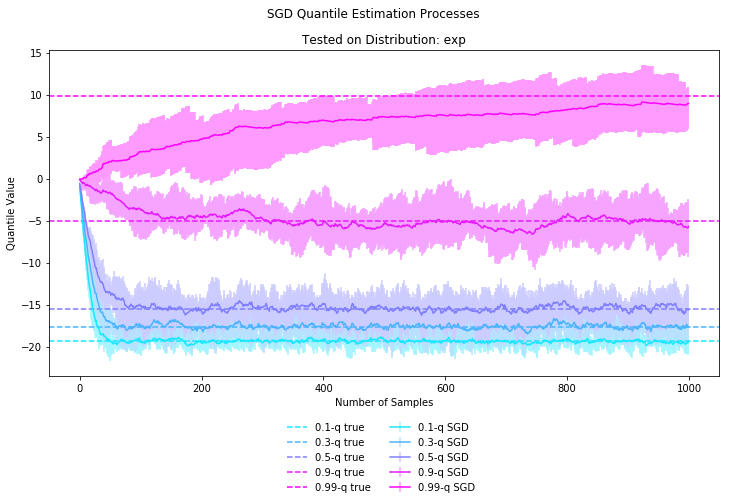

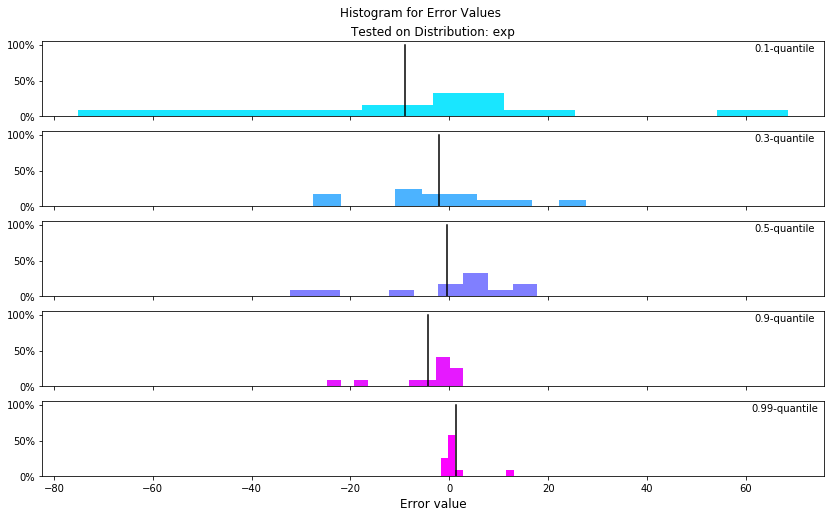

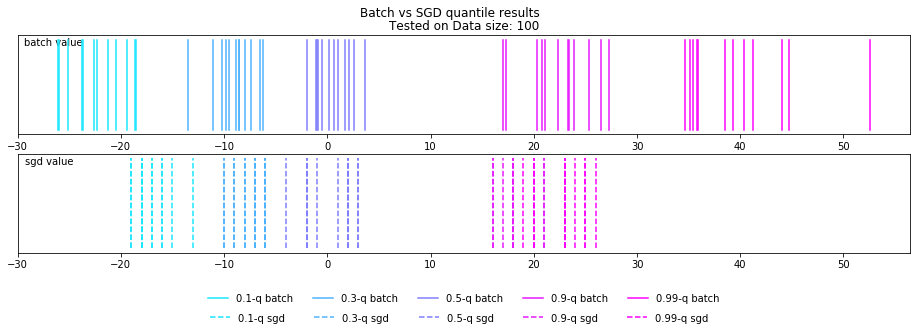

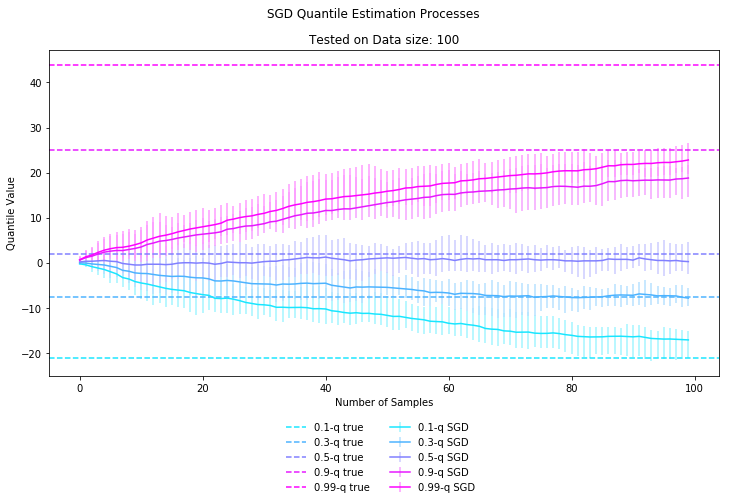

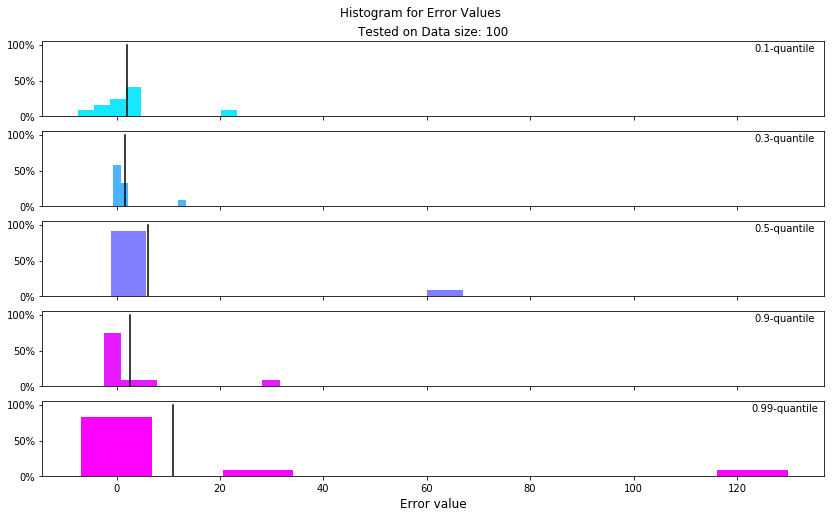

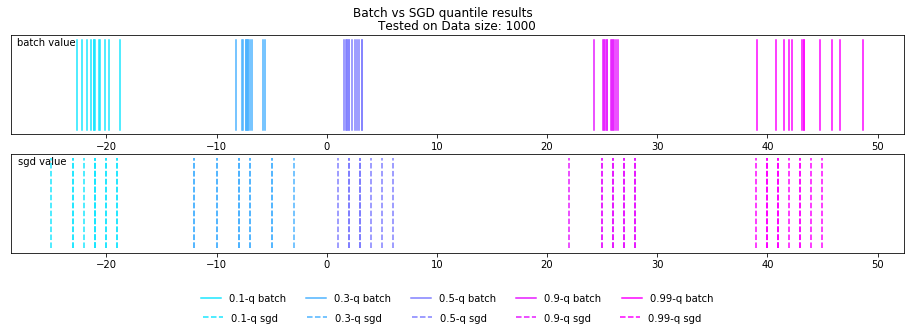

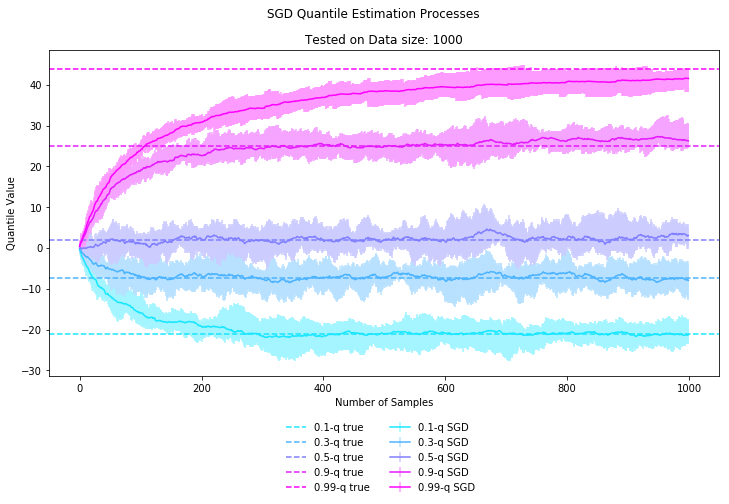

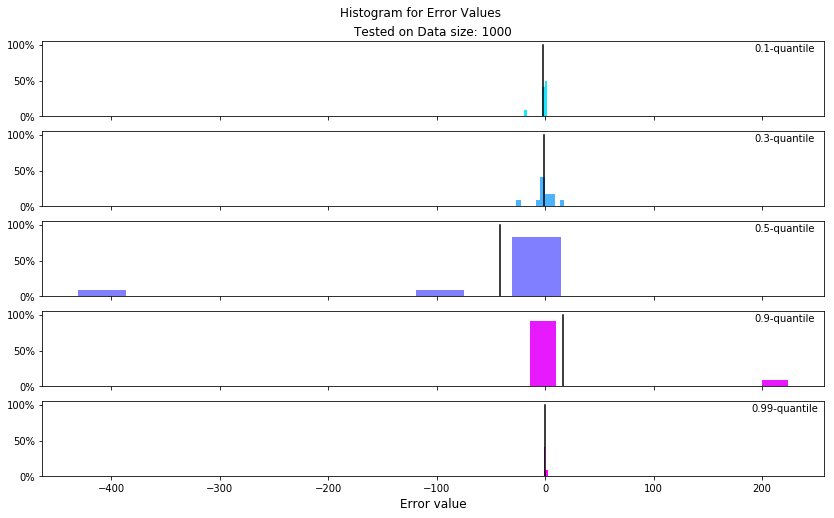

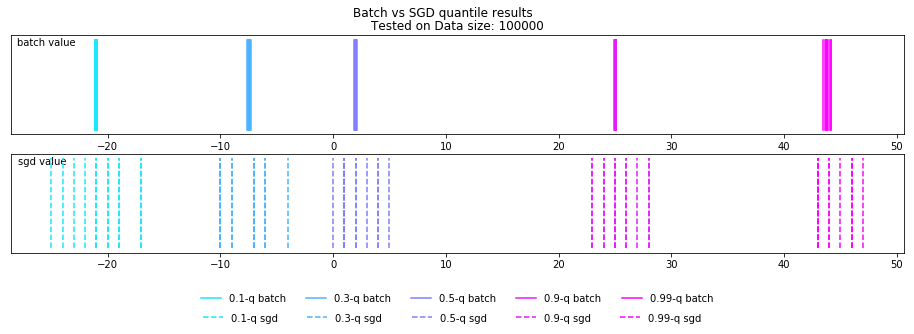

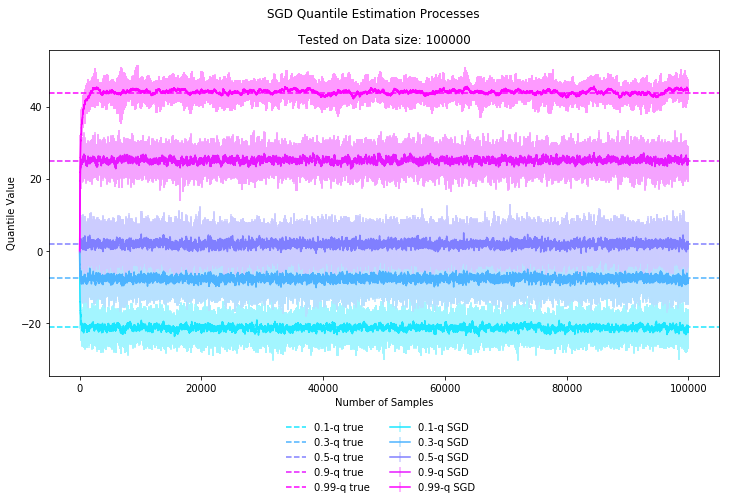

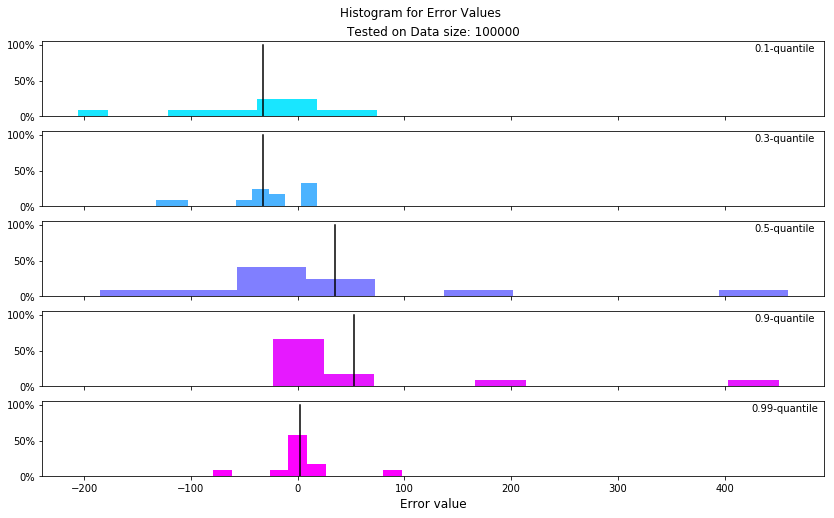

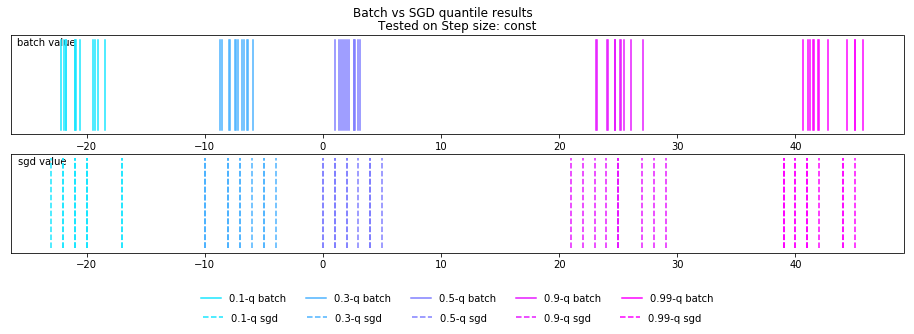

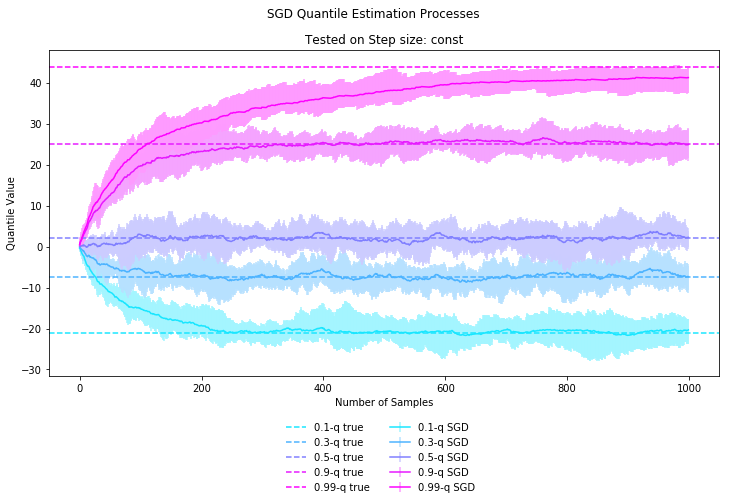

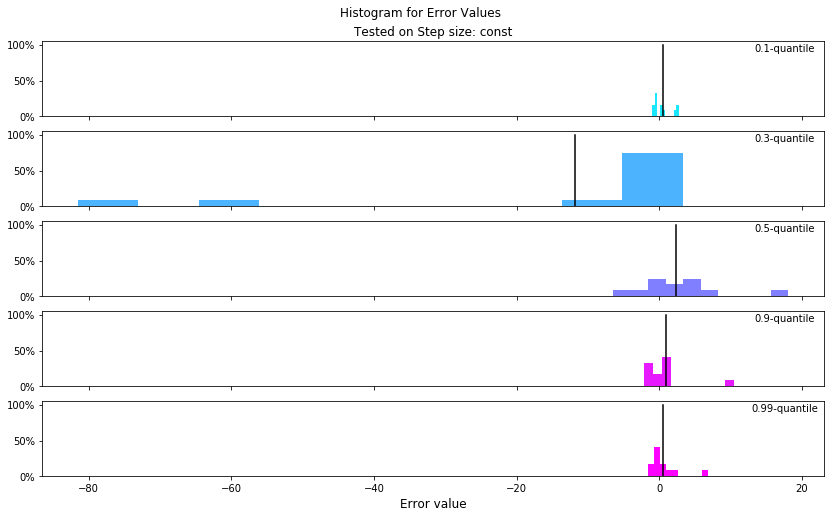

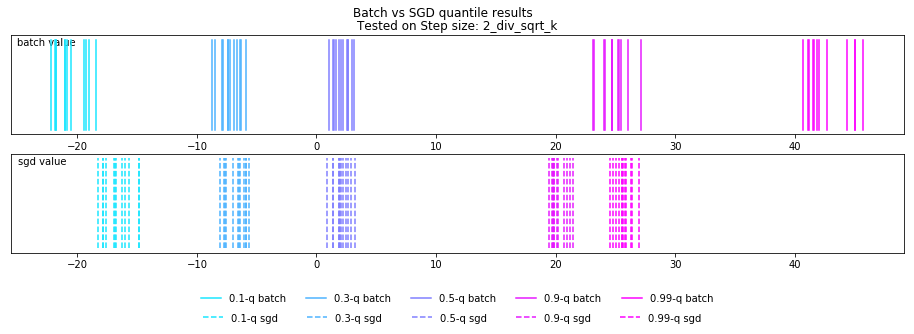

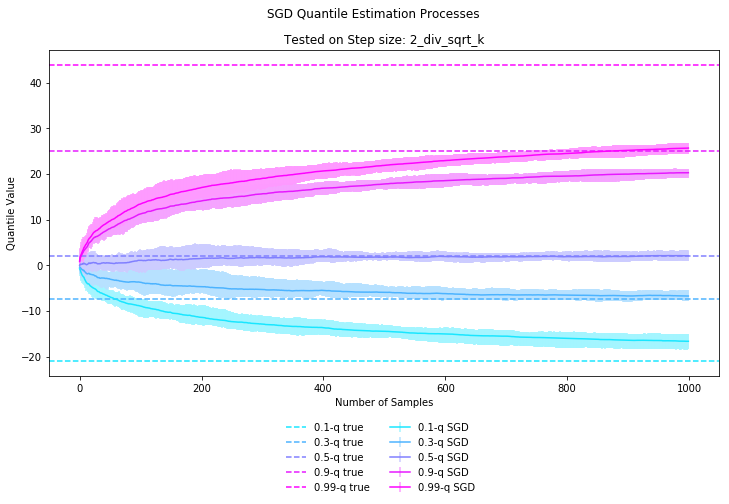

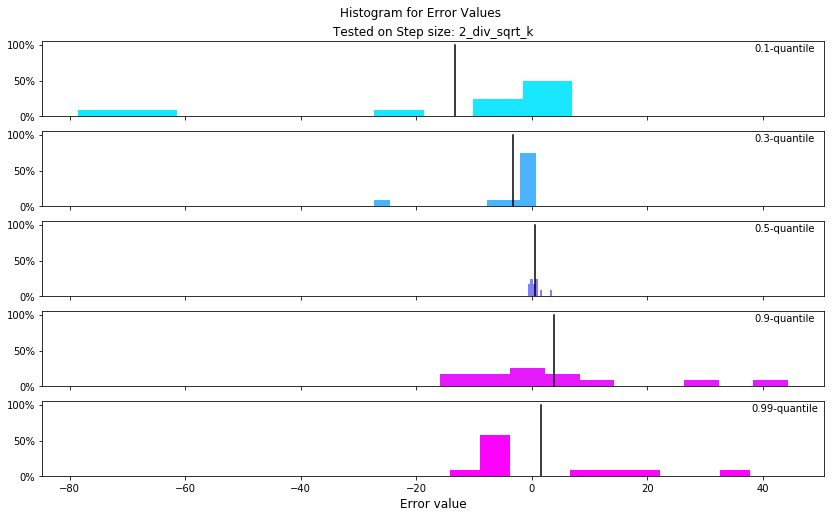

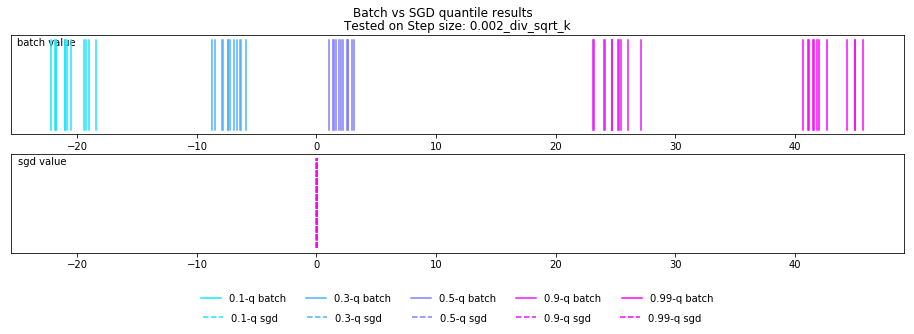

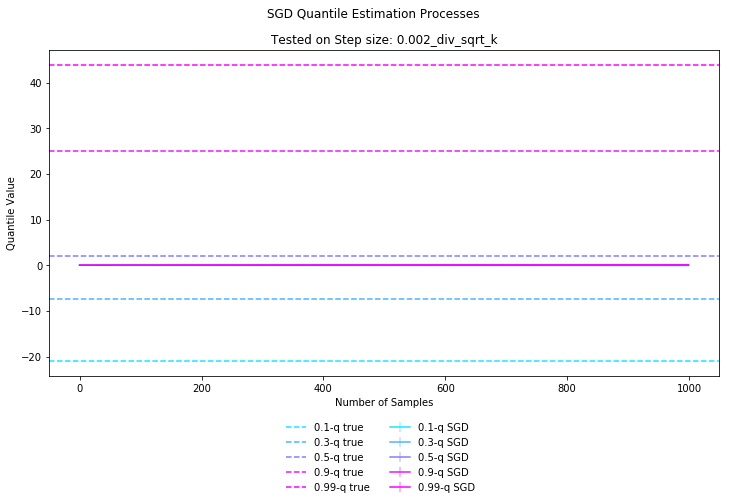

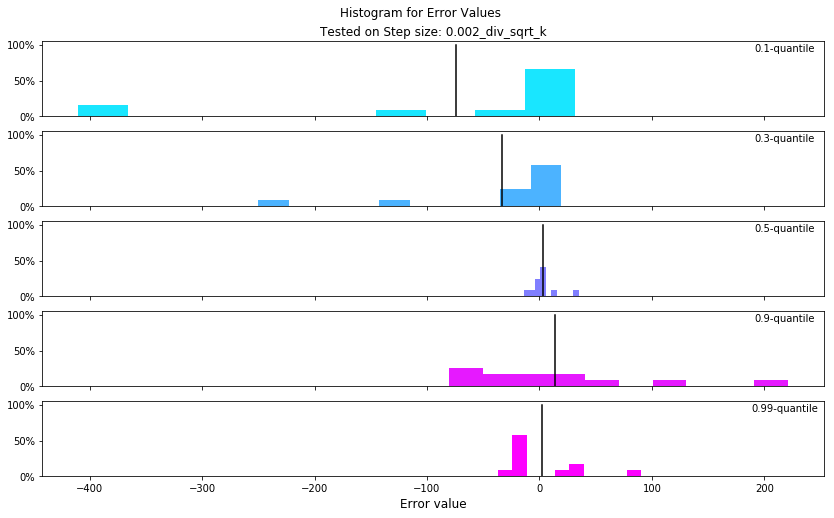

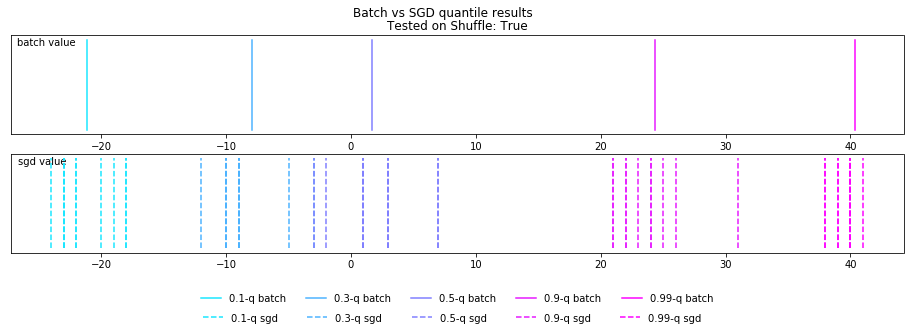

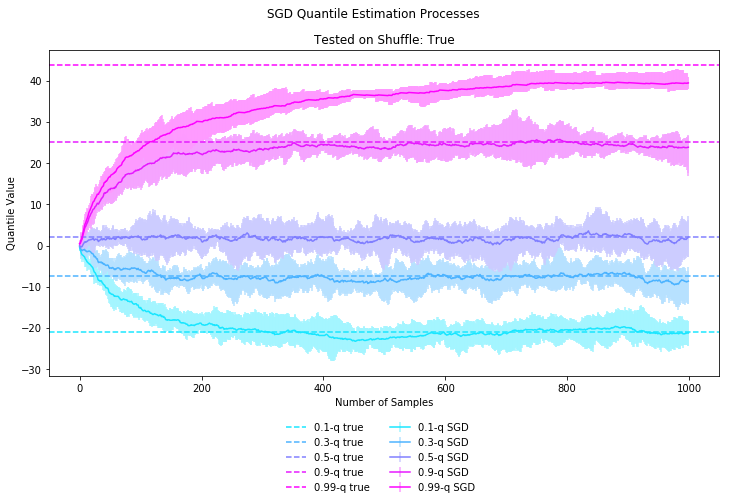

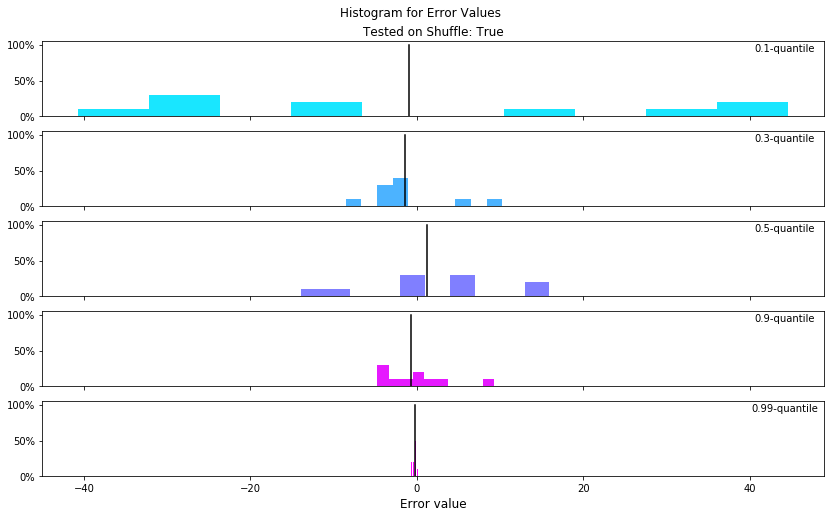

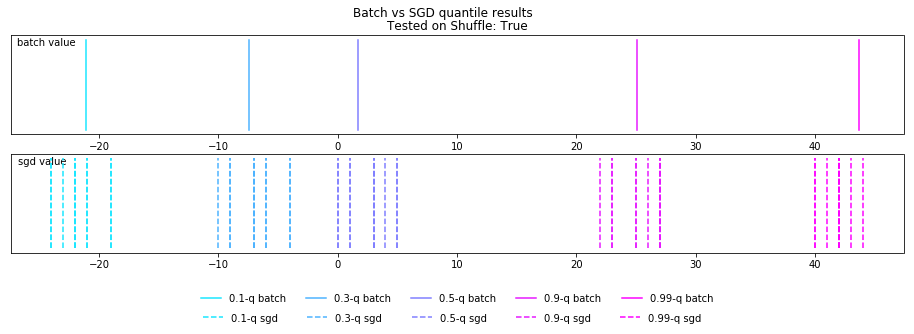

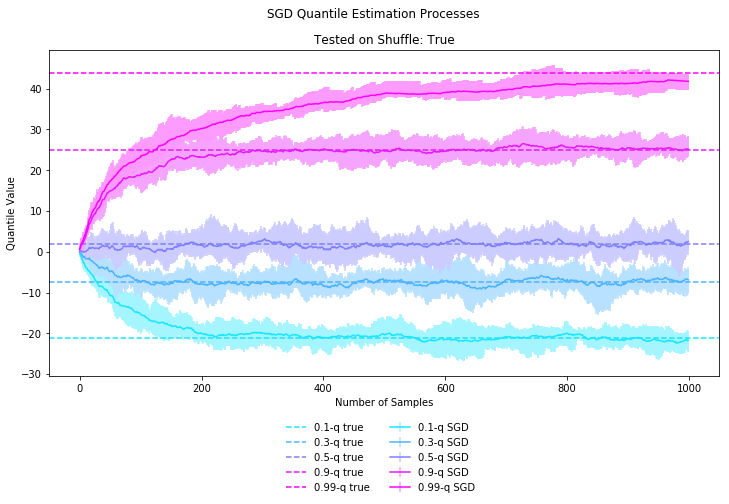

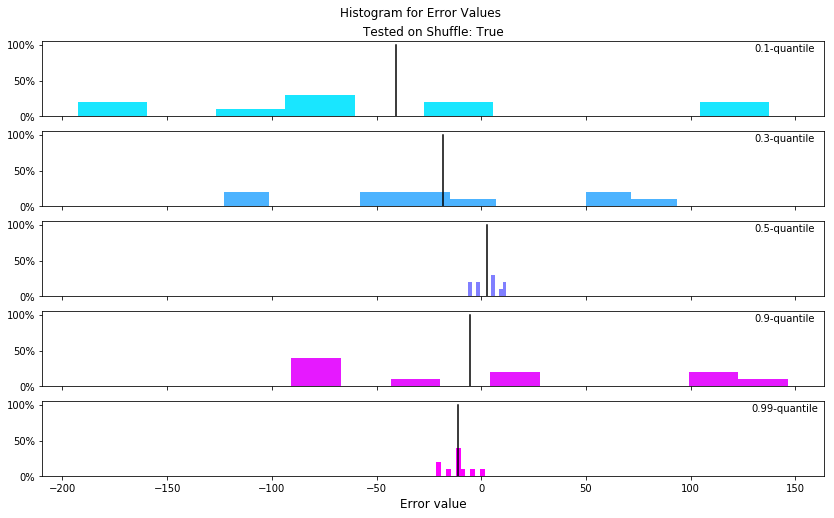

In [43]:
# sgd_lst = ['distro', 'data_size', 'step_size', 'data_sequance']        

def all_sgd_comparisons():
    for t in sgd_lst:
        print (t)
        folder_name = "Experiment_results/SGD/"+t+"/"
        if t=='distro':
            quantile_sgd_compare(folder_name, distros, [1000], ['const'], True)
        elif t=='data_size':
            quantile_sgd_compare(folder_name, ['gau 1'], [100, 1000, 100000], ['const'], True)
        elif t=='step_size':
            quantile_sgd_compare(folder_name, ['gau 1'], [1000], stepsizes, True)
        elif t=='data_sequence':
            quantile_sgd_compare(folder_name, ['gau 1', 'gau 1'], [1000], ['const'], False, True)
            
            
all_sgd_comparisons()

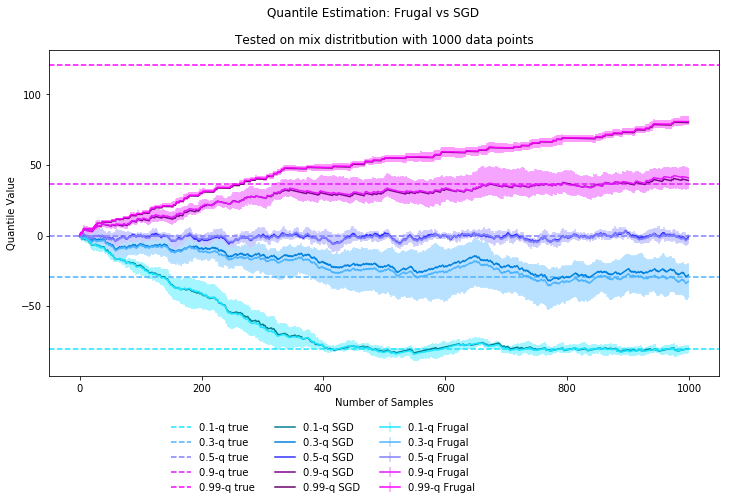

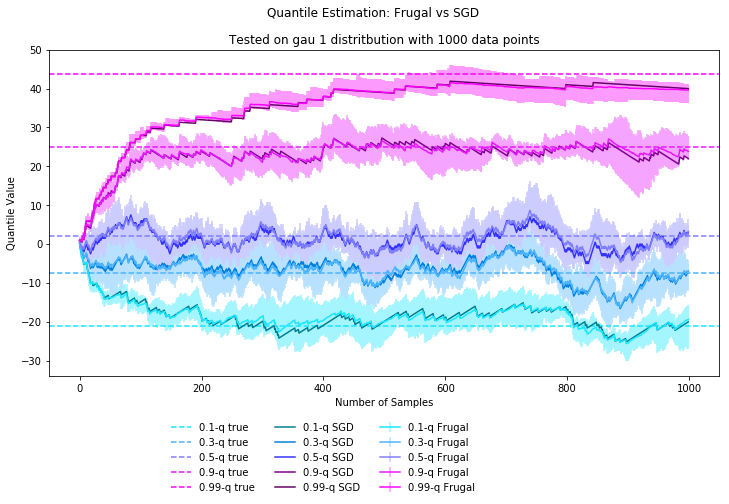

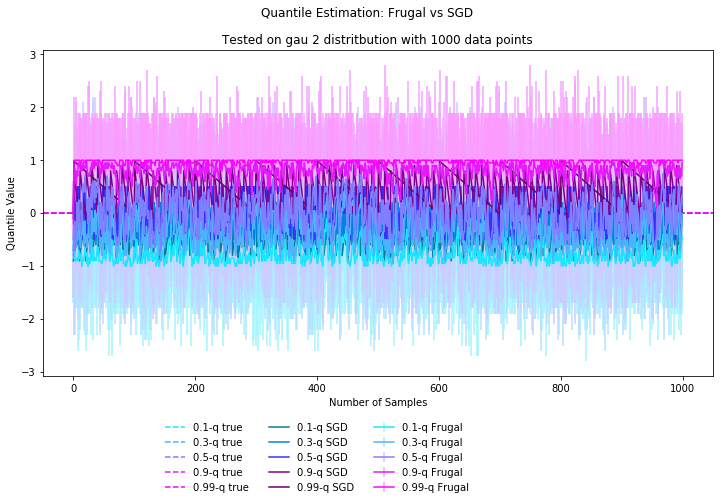

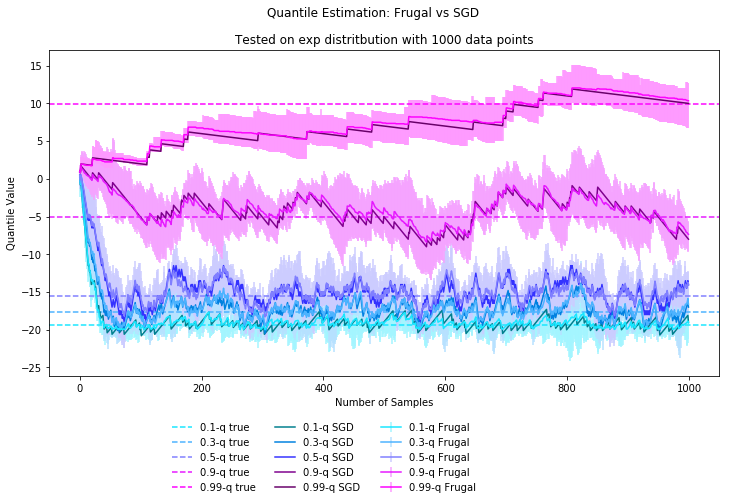

In [42]:
def sgd_frugal_compare(distro_lst, datasize, tau_lst=tau_vals):
    #distro changes, use the biggest datasize, do not shuffle
    for distro in distro_lst:
        q_true = get_q_true(distro, tau_lst)
        dataset = get_dataset(distro, datasize, False)
        q_batches = get_q_batches(dataset, tau_lst)
        
        sgd_res, sgd_proc = get_q_ests(dataset, 'const', tau_lst)
        
        N_frugal = 20
        frugal_res = np.zeros((N_frugal, len(tau_lst)))
        frugal_proc = np.zeros((N_frugal, len(tau_lst), datasize))
        for i in range(N_frugal):
            frugal_res[i], frugal_proc[i] = get_q_ests(dataset, 'frugal', tau_lst)
        
        ax_name = 'Tested on '+distro+' distritbution with '+str(datasize)+' data points'
        fig, lgd = plot_procs(ax_name, tau_vals, q_true, frugal_proc, sgd_proc)
        title = fig.suptitle('Quantile Estimation: Frugal vs SGD')

        fd = "Experiment_results/Frugal_SGD/"
        plt.savefig(fd+distro+'.png', bbox_extra_artists=(lgd, title), bbox_inches='tight')
        
        
sgd_frugal_compare(distros, 1000)

<!---
### Always have $q_k = x$ for each x in the data stream

When $x - q_k > 0$, we have $l(q_k) = \tau(x-q_k)$:
\begin{align}
q_{k+1} & = q_k - \frac{l(q_k)}{l'(q_k)} \\
        & = q_k - \frac{\tau(x-q_k)}{-\tau} \\
        & = q_k - (- x + q_k) \\
        & = x
\end{align}

Same happens when $x - q_k < 0$
-->